In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
# To import data from kaggle.
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
    'IM_SIZE' : 256
}

### Loading Dataset

In [4]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [5]:
train_set = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical', class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb', batch_size=CONFIGURATION["BATCH_SIZE"], image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True, seed=99)


val_set = tf.keras.utils.image_dataset_from_directory(
    val_directory, labels='inferred', label_mode='categorical', class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb', batch_size=CONFIGURATION["BATCH_SIZE"], image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True, seed=99)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


### Data Visualization

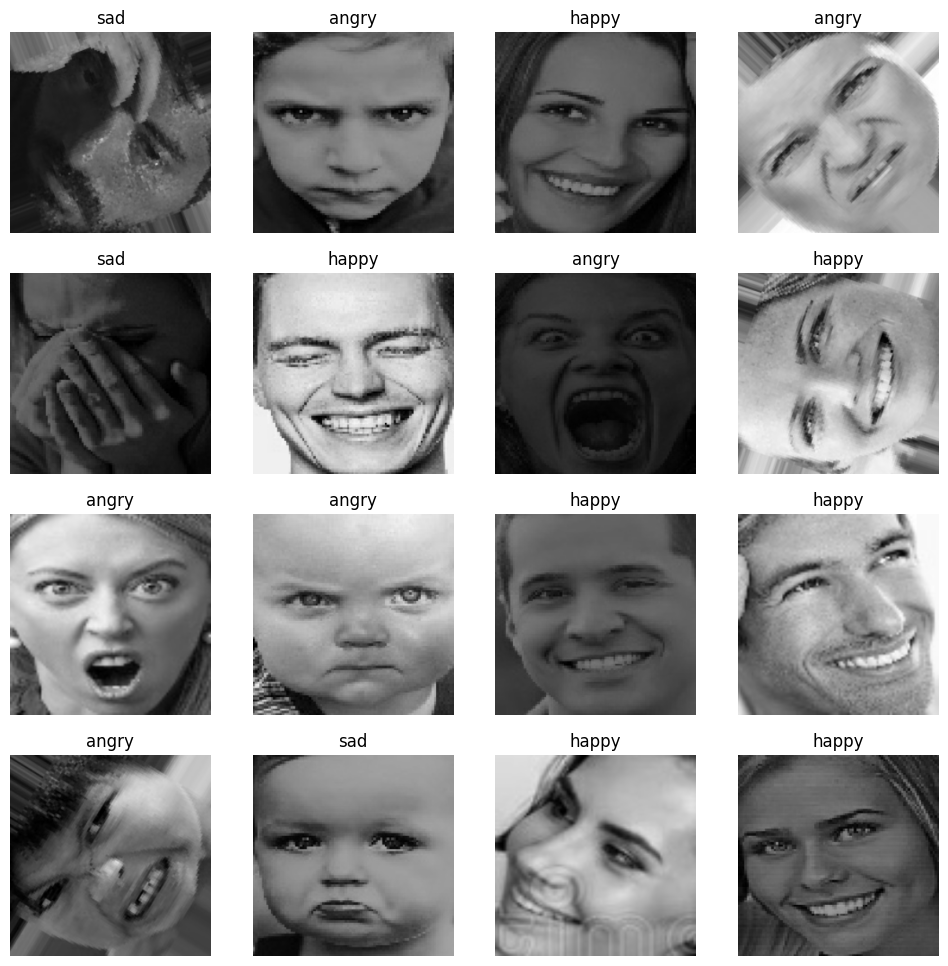

In [6]:
plt.figure(figsize = (12,12))

for images, labels in train_set.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

### Data Augmentation

#### Simple Augmentation

In [7]:
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])
def augment_layer(image, label):
  return augment_layers(image, training = True), label

#### CutMix Augmentation

In [8]:
IM_SIZE = CONFIGURATION['IM_SIZE']
def box(lamda):
  # Generate a center of the bounding box randomly
  rx = tf.cast(tfp.distributions.Uniform(low=0.0,high=IM_SIZE).sample(1)[0], dtype = tf.dtypes.int32)
  ry = tf.cast(tfp.distributions.Uniform(low = 0.0, high = IM_SIZE).sample(1)[0], dtype = tf.dtypes.int32)

  # Get the random width and height of the bounding box.
  rw = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype = tf.dtypes.int32)
  rh = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype = tf.dtypes.int32)


  # Making sure that the bounding box in entirely inside the image.
  rx = tf.clip_by_value(rx - rw//2, 0, IM_SIZE)
  ry = tf.clip_by_value(ry - rh//2, 0, IM_SIZE)

  x_bottom_right = tf.clip_by_value(rx + rw//2, 0, IM_SIZE)
  y_bottom_right = tf.clip_by_value(ry + rh//2, 0, IM_SIZE)

  rw = x_bottom_right - rx
  if(rw == 0):
    rw = 1
  rh = y_bottom_right - ry
  if(rh == 0):
    rh = 1

  return ry, rx, rh, rw

In [9]:
# This will mix the two images, of the two datasets as image = lamda * image_1 + (1 - lamda) * image_2
def cutmix(train_set_1, train_set_2):


  (image_1, label_1), (image_2, label_2) = train_set_1, train_set_2

  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  ry, rx, rw, rh = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image_2, ry, rx, rh, rw)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, ry, rx, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, ry, rx, rh, rw)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, ry, rx, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1 - (rh * rw)/(IM_SIZE * IM_SIZE), dtype = tf.dtypes.float32)

  label = lamda * tf.cast(label_1, dtype = tf.dtypes.float32) + (1 - lamda) * tf.cast(label_2, dtype = tf.dtypes.float32)

  return image, label




In [10]:
# Mixing Shuffled sets and applying cutmix to get new values.
train_set_1 = train_set.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_set_2 = train_set.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

# Mix up the dataset which contain shuffled images.
mixed_set = tf.data.Dataset.zip((train_set_1, train_set_2))

### The Model

#### Preparing Dataset for Training

In [13]:
training_dataset = train_set.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
validation_dataset = val_set.prefetch(tf.data.AUTOTUNE)

In [14]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])


#### Lenet Model

##### Definition of the model

In [12]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

##### Training

In [ ]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss = loss_function, metrics = metrics)

In [ ]:
history = lenet_model.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"], verbose = 1)

Epoch 1/20
213/213 [==============================] - 103s 479ms/step - loss: 0.6197 - accuracy: 0.8044 - top_k_accuracy: 0.9476 - val_loss: 0.9635 - val_accuracy: 0.6058 - val_top_k_accuracy: 0.8701
Epoch 2/20
213/213 [==============================] - 102s 474ms/step - loss: 0.6286 - accuracy: 0.7935 - top_k_accuracy: 0.9423 - val_loss: 0.7507 - val_accuracy: 0.6967 - val_top_k_accuracy: 0.8885
Epoch 3/20
213/213 [==============================] - 101s 467ms/step - loss: 0.5793 - accuracy: 0.8186 - top_k_accuracy: 0.9494 - val_loss: 0.5366 - val_accuracy: 0.7801 - val_top_k_accuracy: 0.9320
Epoch 4/20
213/213 [==============================] - 100s 465ms/step - loss: 0.5958 - accuracy: 0.8063 - top_k_accuracy: 0.9488 - val_loss: 0.5682 - val_accuracy: 0.7695 - val_top_k_accuracy: 0.9280
Epoch 5/20
213/213 [==============================] - 98s 453ms/step - loss: 0.5910 - accuracy: 0.8206 - top_k_accuracy: 0.9525 - val_loss: 0.5971 - val_accuracy: 0.7511 - val_top_k_accuracy: 0.9342
E

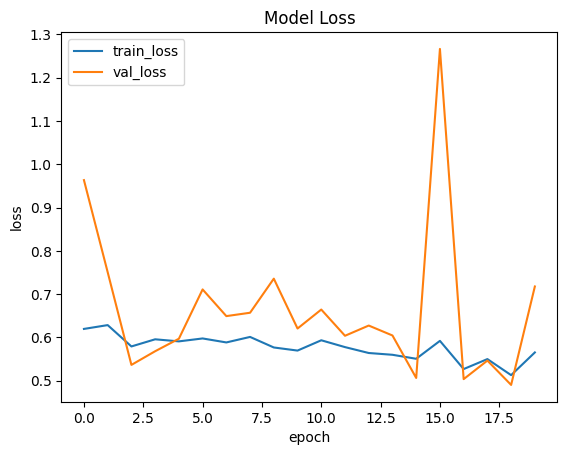

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

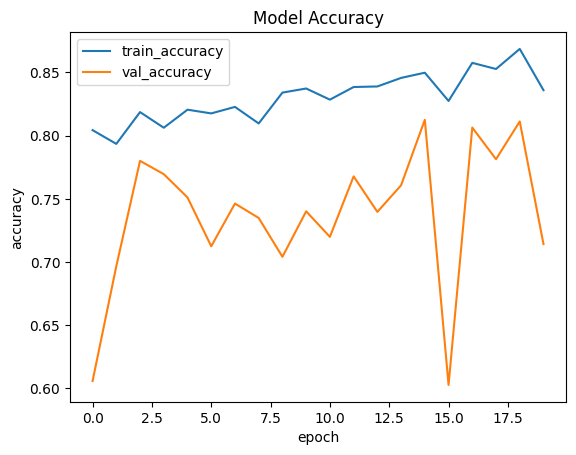

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

##### Evaluation and Testing

In [86]:
lenet_model.evaluate(val_set)

RuntimeError: ignored

In [87]:
image_read = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/520857.jpg")

t_image = tf.constant(image_read, dtype = tf.dtypes.float32)
print(t_image.shape)

t_image = tf.expand_dims(t_image, axis = 0)
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(lenet_model(t_image), axis = -1).numpy()[0]])

(90, 90, 3)
sad


In [ ]:
plt.figure(figsize = (12,12))

for images, labels in val_set.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(f"True Label : {CONFIGURATION['CLASS_NAMES'][tf.argmax(labels[i], axis = 0)]}" + "\n" + f"PredictedLabel : {CONFIGURATION['CLASS_NAMES'][tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]]}")
    plt.axis("off")


In [ ]:
predicted = []
labels = []

for image, label in validation_dataset:
  predicted.append(lenet_model(image))
  labels.append(label.numpy())

pred_values = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
true_values = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

cm = confusion_matrix(true_values, pred_values)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### Resnet Model

##### Model Definition and Stucture

In [15]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [16]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


In [17]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)


##### Model Training

In [18]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

In [19]:
loss_function = CategoricalCrossentropy()

In [20]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name = "top_k_accuracy")]

In [21]:
resnet_34.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE'] * 100), loss = loss_function, metrics = metrics)

##### Callbacks

In [22]:
checkpoint_callback = ModelCheckpoint('checkpoint/', monitor = 'val_accuracy', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 3)

In [23]:
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001, verbose = 1)

In [24]:
es_callback = EarlyStopping(
    monitor = 'val_loss', min_delta = 0.01, patience = 5, verbose = 1,
    mode = 'auto', baseline = None, restore_best_weights = True
)

In [25]:
callbacks = [reduce_lr_callback, es_callback]

##### Training

In [26]:
history = resnet_34.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"], verbose = 1, callbacks = callbacks)

Epoch 1/20
213/213 [==============================] - 99s 327ms/step - loss: 1.6223 - accuracy: 0.4432 - top_k_accuracy: 0.7645 - val_loss: 2.7838 - val_accuracy: 0.3288 - val_top_k_accuracy: 0.5588 - lr: 0.1000
Epoch 2/20
213/213 [==============================] - 64s 297ms/step - loss: 1.0506 - accuracy: 0.4805 - top_k_accuracy: 0.7742 - val_loss: 1.0321 - val_accuracy: 0.4868 - val_top_k_accuracy: 0.7726 - lr: 0.1000
Epoch 3/20
213/213 [==============================] - 65s 302ms/step - loss: 1.0424 - accuracy: 0.4865 - top_k_accuracy: 0.7735 - val_loss: 1.0241 - val_accuracy: 0.5031 - val_top_k_accuracy: 0.7779 - lr: 0.1000
Epoch 4/20
213/213 [==============================] - 64s 299ms/step - loss: 1.0427 - accuracy: 0.4836 - top_k_accuracy: 0.7713 - val_loss: 17.2166 - val_accuracy: 0.4772 - val_top_k_accuracy: 0.7546 - lr: 0.1000
Epoch 5/20
213/213 [==============================] - ETA: 0s - loss: 1.0396 - accuracy: 0.4892 - top_k_accuracy: 0.7725
Epoch 5: ReduceLROnPlateau red

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

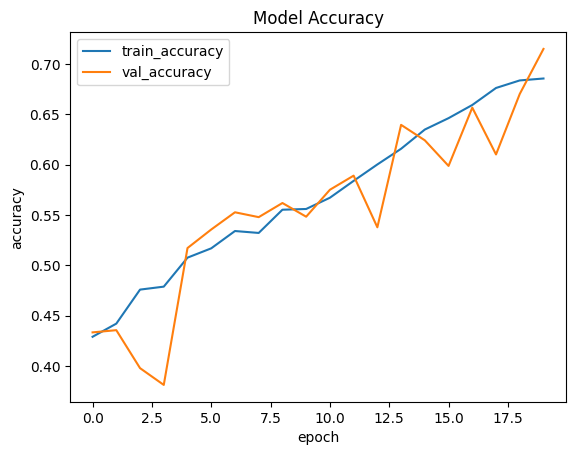

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

##### Evaluation and Testing

In [41]:
resnet_34.evaluate(val_set)

72/72 [==============================] - 5s 66ms/step - loss: 0.6589 - accuracy: 0.7151 - top_k_accuracy: 0.9056


[0.6588602066040039, 0.7151009440422058, 0.9056189656257629]

In [42]:
image_read = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/520857.jpg")

t_image = tf.constant(image_read, dtype = tf.dtypes.float32)
print(t_image.shape)

t_image = tf.expand_dims(t_image, axis = 0)
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(resnet_34(t_image), axis = -1).numpy()[0]])

(90, 90, 3)
happy


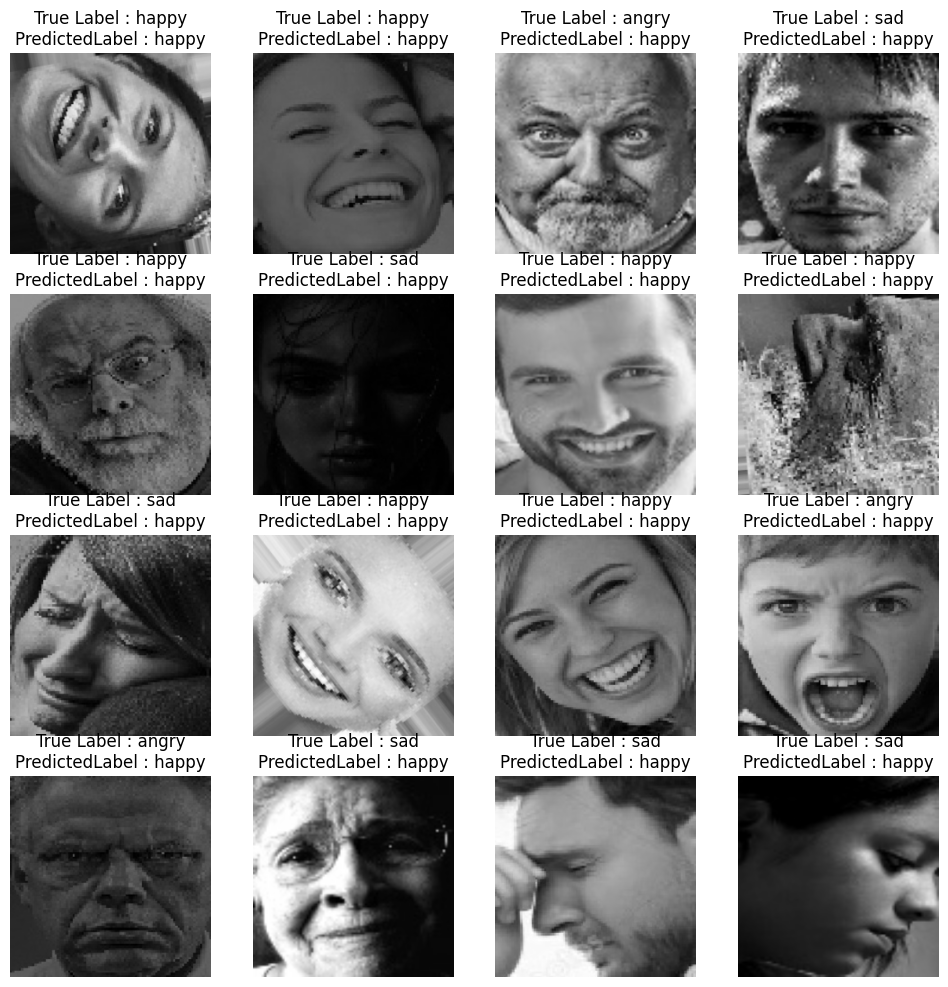

In [43]:
plt.figure(figsize = (12,12))

for images, labels in val_set.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(f"True Label : {CONFIGURATION['CLASS_NAMES'][tf.argmax(labels[i], axis = 0)]}" + "\n" + f"PredictedLabel : {CONFIGURATION['CLASS_NAMES'][tf.argmax(resnet_34(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[0]]}")
    plt.axis("off")


[[314 120  81]
 [ 32 928  46]
 [ 64 222 471]]


Text(0.5, 58.7222222222222, 'Predicted')

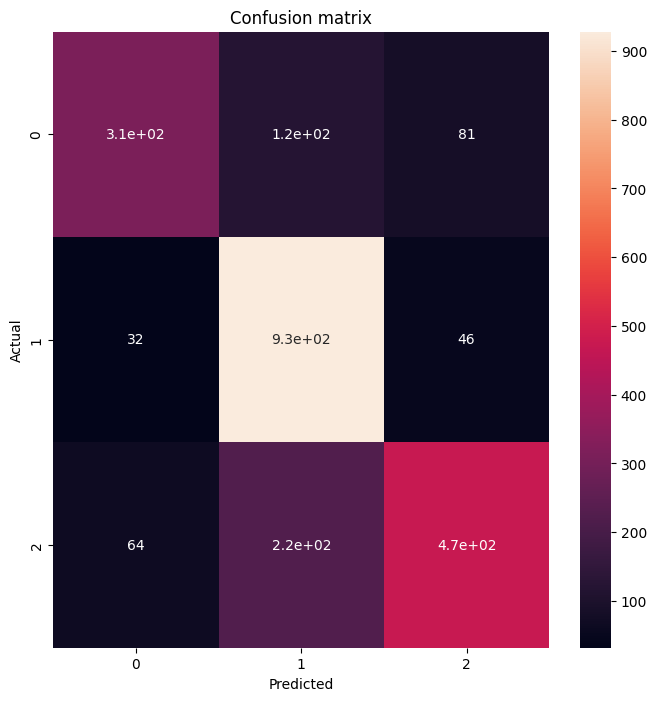

In [ ]:
predicted = []
labels = []

for image, label in validation_dataset:
  predicted.append(resnet_34(image))
  labels.append(label.numpy())

pred_values = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
true_values = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

cm = confusion_matrix(true_values, pred_values)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')